In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Exercise 1b
#### Lars Kühmichel, Ergin Kohen Sagner, Nicolas Wolf

## 3 Nearest Neighbor Classification on Real Data
### 3.1 Exploring the Data

<div style="color:green; font-weight: bold">
Comment: same as the sample solution
</div>

In [2]:
from sklearn.datasets import load_digits

digits = load_digits()

print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

print(data.dtype)

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])
float64


(8, 8)


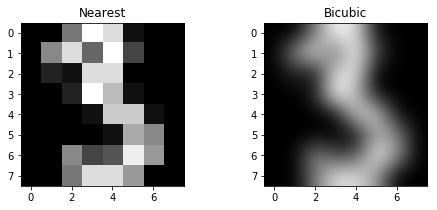

In [3]:
img = images[3]

print(img.shape)
assert 2 == len(img.shape)

fig, axes = plt.subplots(1, 2, num=1, figsize=(8, 3))
axes[0].imshow(img, interpolation="nearest", cmap="gray")
axes[0].set_title("Nearest")
axes[1].imshow(img, interpolation="bicubic", cmap="gray")
axes[1].set_title("Bicubic")
plt.show()

In [4]:
from sklearn import model_selection

X_all = data
Y_all = target

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_all, Y_all, test_size=0.4, random_state=0)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(1078, 64) (719, 64) (1078,) (719,)


### 3.2 Distance function computation using loops

<div style="color:green; font-weight: bold">
Comment: we used np.linalg.norm which does the same as sqrt(sum(square(...))) in this case
</div>

In [5]:
def dist_loop(training, test):
    N = training.shape[0]
    M = test.shape[0]
    D = training.shape[1]
    #print(N, M, D)
    result = np.zeros((N, M))
    
    for n in range(N):
        for m in range(M):
            result[n, m] = np.linalg.norm(training[n] - test[m])
            
    return result
    

### 3.3 Distance Function using vectorization

$$
\begin{align*}
    dist(A,B) &= \sqrt{\sum(A-B)^2}\\
        &= \sqrt{\sum A^2 -2\sum AB + \sum B^2}\qquad&&\text{pointwise multiplication}\\
        &= \sqrt{\sum A^2 - 2 A\cdot B + \sum B^2}\qquad&&\text{dot product}
\end{align*}
$$


<div style="color:green; font-weight: bold">
Comment: We also tested both versions of the vectorized distance function, but we used np.newaxis for adding dimensions. This is only a different syntax but otherwise equivalent
</div>

In [6]:
def dist_vec(training, test):
    return np.sqrt(np.square(training[:,np.newaxis] - test).sum(axis=2))


In [7]:
def dist_vec_2(training, test):
    sums = np.sum(np.square(training)[:,np.newaxis,:], axis=2) - 2*training.dot(test.T) + np.sum(np.square(test), axis=1)
    return np.sqrt(sums)

In [8]:
from sklearn.metrics import pairwise_distances

%timeit dist_loop(X_train, X_test)
%timeit dist_vec(X_train, X_test)
%timeit dist_vec_2(X_train, X_test)
%timeit pairwise_distances(X_train, X_test)

5.63 s ± 60.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
508 ms ± 33.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
19.9 ms ± 246 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.4 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<div style="color:green; font-weight: bold">
Comment: Our functions give the same results. The reason for the different results in the sample solution is probably some rounding error which didn't occur here
</div>

In [9]:
distances_loop = dist_loop(X_train, X_test)
distances_vec = dist_vec(X_train, X_test)
distances_vec_2 = dist_vec_2(X_train, X_test)
distances_sklearn = pairwise_distances(X_train, X_test)
print(np.array_equal(distances_loop, distances_vec))
print(np.array_equal(distances_loop, distances_vec_2))
print(np.array_equal(distances_loop, distances_sklearn))

True
True
True


### 3.4 Implement the k-nearest neighbor classifier

<div style="color:green; font-weight: bold">
Comment: We use argpartition instead of argsort. The partition function works like the partition function in quicksort. It takes an array and an index 'k' and returns an array in which the element with index 'k' is in its correct place. The elements on the left are smaller, those on the right are larger but not necessarily sorted. The function argpartition returns the corresponding indices from the original array. The advantage over argsort is, that it doesn't have to do a full sort and is thus faster.
<br>
Also we used bincount to avoid an additional loop
</div>

In [10]:
def knn(training, training_labels, test, k):
    distance_matrix = dist_vec_2(training, test)
    # matrix with indices where the first k entries in each column have the smallest distance
    k_min = np.argpartition(distance_matrix, k, axis=0)
    k_min = k_min[:k,:]
    
    classified = np.zeros(k_min.shape[1], dtype=np.uint8)
    for i in range(k_min.shape[1]):
        # label with the most occurences
        classified[i] = np.bincount(training_labels[k_min[:,i]]).argmax()
    
    return classified
    


<div style="color:green; font-weight: bold">
Comment: We only compared 3 and 9 (enough for the exercise). Also we didn't plot the error but only checked the dependency numerically.
</div>

In [11]:
def test_knn(X_train, Y_train, X_test, Y_test, k):
    classified = knn(X_train, Y_train, X_test, k)
    incorrect = classified != Y_test
    return np.mean(incorrect)
    
X_train_39 = X_train[(Y_train == 3) | (Y_train == 9)]
Y_train_39 = Y_train[(Y_train == 3) | (Y_train == 9)]
X_test_39 = X_test[(Y_test == 3) | (Y_test == 9)]
Y_test_39 = Y_test[(Y_test == 3) | (Y_test == 9)]
    
#for k in [1,3,5,9,17,33]:
for k in range(1,34,2):
    #print(f"k = {k}:\t{test_knn(X_train,Y_train,X_test,Y_test,k)*100:0.2f}%")
    print(f"k = {k}:\t{test_knn(X_train_39,Y_train_39,X_test_39,Y_test_39,k)*100:0.2f}%")

k = 1:	1.39%
k = 3:	0.69%
k = 5:	0.69%
k = 7:	0.00%
k = 9:	0.69%
k = 11:	0.00%
k = 13:	0.00%
k = 15:	0.69%
k = 17:	0.69%
k = 19:	2.08%
k = 21:	2.08%
k = 23:	2.78%
k = 25:	2.08%
k = 27:	2.08%
k = 29:	2.08%
k = 31:	2.08%
k = 33:	2.08%


## 4 Cross Validation

<div style="color:green; font-weight: bold">
Comment: The cross_validation function is essentially the same as the one in the sample solution, except for some minor details. We created the training data from the folds without a loop by using a mask and we use a different method to calculate the error (error = np.mean(classified != test_labels))<br>
We only ran the function for shuffled data since this was asked in the exercise, but it is interesting to see the difference.<br>
We decided to plot the errors and times for different values of k instead of a table because it is clearer
</div>

C:\Users\nwolf\Anaconda3\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


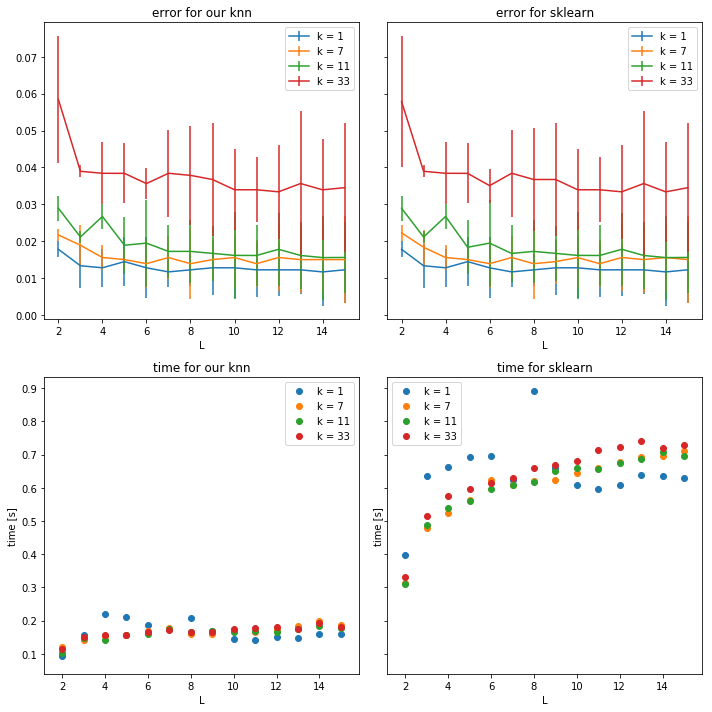

In [12]:
from sklearn.neighbors import KNeighborsClassifier
import time

def split_folds(data, target, L):
    permutation = np.random.permutation(len(data))
    data_permuted = data[permutation]
    target_permuted = target[permutation]
    return np.array(np.array_split(data_permuted, L)), np.array(np.array_split(target_permuted, L))
    
def cross_validation(data, target, L, k):
    X_folds, Y_folds = split_folds(data, target, L)
    
    
    errors = np.zeros(L)
    errors_skl = np.zeros(L)
    
    time_knn = time_skl = 0
    
    for l in range(L):
        X_l = X_folds[l]
        Y_l = Y_folds[l]
        mask = np.arange(len(X_folds)) != l
        X_rest = X_folds[np.arange(len(X_folds)) != l]
        Y_rest = Y_folds[np.arange(len(Y_folds)) != l]
        X_rest = np.concatenate(X_rest)
        Y_rest = np.concatenate(Y_rest)
        
        start = time.time()
        errors[l] = test_knn(X_rest, Y_rest, X_l, Y_l, k)
        time_knn += time.time() - start
        
        start = time.time()
        neigh = KNeighborsClassifier(n_neighbors=k)
        neigh.fit(X_rest, Y_rest)
        classified = neigh.predict(X_l)
        incorrect_skl = classified != Y_l
        errors_skl[l] = np.mean(incorrect_skl)
        time_skl += time.time() - start
    
    return errors, errors_skl, time_knn, time_skl

mean_knn = []
std_knn = []
mean_skl = []
std_skl = []
times_knn = []
times_skl = []

L_values = [i for i in range(2, 16)]
k_values = [1, 7, 11, 33]
for index, k in enumerate(k_values):
    mean_knn.append([])
    std_knn.append([])
    mean_skl.append([])
    std_skl.append([])
    times_knn.append([])
    times_skl.append([])
    for L in L_values:
        #print(L)
        errors_knn, errors_skl, time_knn, time_skl = cross_validation(data, target, L, k)
        mean_knn[index].append(np.mean(errors_knn))
        std_knn[index].append(np.std(errors_knn))
        mean_skl[index].append(np.mean(errors_skl))
        std_skl[index].append(np.std(errors_skl))
        times_knn[index].append(time_knn)
        times_skl[index].append(time_skl)
    
    
fig, axs = plt.subplots(2, 2, sharey='row', tight_layout=True, num=2, figsize=(10,10))
axs[0,0].title.set_text("error for our knn")
axs[0,0].set_xlabel("L")
axs[0,1].title.set_text("error for sklearn")
axs[0,1].set_xlabel("L")
axs[1,0].title.set_text("time for our knn")
axs[1,0].set_xlabel("L")
axs[1,0].set_ylabel("time [s]")
axs[1,1].title.set_text("time for sklearn")
axs[1,1].set_xlabel("L")
axs[1,1].set_ylabel("time [s]")

for index, k in enumerate(k_values):

    axs[0,0].errorbar(L_values, np.array(mean_knn[index]), yerr=np.array(std_knn[index]), label=f"k = {k}")
    axs[0,1].errorbar(L_values, np.array(mean_skl[index]), yerr=np.array(std_skl[index]), label=f"k = {k}")

    axs[1,0].scatter(L_values, np.array(times_knn[index]), label=f"k = {k}")
    axs[1,1].scatter(L_values, np.array(times_skl[index]), label=f"k = {k}")
    
axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()

plt.show()